In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from irt import IRTModel
from sklearn import svm
from sklearn.linear_model import SGDRegressor, LinearRegression, BayesianRidge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from beta_irt.visualization.plots import newline
from beta_irt.visualization.plots import plot_parameters
from irt import beta_irt
from sklearn.decomposition import PCA
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib import gridspec


# Data set

In [3]:
# Path
path_data = './data/'
path_uci = './data/UCI - 45/'

# Name of data set
name = 'polynomial'

# Read csv
data = pd.read_csv(path_uci + name + '.csv')
data = data.dropna()

Parameters:

In [4]:
rd = 42
noise_std = 0
max_std = 16

## Pre processing

Variable selection:

In [5]:
X = data.iloc[:, 0].values.reshape(-1,1)
y = data.iloc[:, 1]

Split data:

In [6]:
# Split data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = rd)

Generate outliers observing data scatter:

In [7]:
X_outliers = np.array([[-2], [0], [2], [6]])
y_outliers = pd.Series([100, 150, 200, -100])

In [8]:
X_test = np.append(X_test, X_outliers, axis =0)
y_test = y_test.append(y_outliers)

Principal Component Analysis:

In [ ]:
pca = PCA(n_components= 1)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

Plot train/test split

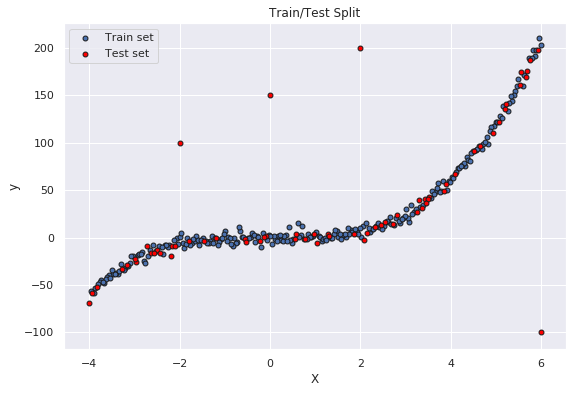

In [9]:
plt.figure(figsize=(9, 6))
plt.scatter(X_train, y_train, label='Train set', s=24, edgecolor='k')
plt.scatter(X_test, y_test, label='Test set', c='red', s=24, edgecolor='k')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Train/Test Split')
plt.legend()
plt.savefig('./Results_IRT/' + name + '/dataset.png')

This part is where data for BIRT models are generated.

In [10]:
# Regression Models
models = [LinearRegression(), BayesianRidge(), svm.SVR(kernel= 'linear'), svm.SVR(kernel = 'rbf', gamma= 'scale', C = 5),\
     KNeighborsRegressor(), DecisionTreeRegressor(), RandomForestRegressor(),\
          AdaBoostRegressor(), MLPRegressor(max_iter=1000, solver= 'lbfgs'), MLPRegressor(hidden_layer_sizes= (50,50), solver = 'lbfgs', max_iter=500, activation='logistic')]

# Generate abilities/parameters for BIRT and other info.
Irt = IRTModel(models= models)
Irt.irtMatrix(X_train = X_train, y_train = y_train, X_test= X_test, y_test= y_test,
              noise_std = noise_std, normalize= True, base_models= True, name= name, rd= rd)

In [11]:
Irt.irt_matrix.head()

,LinearRegression,BayesianRidge,SVR,SVR,KNeighborsRegressor,DecisionTreeRegressor,RandomForestRegressor,AdaBoostRegressor,MLPRegressor,MLPRegressor,Optimal,Average,Worst
203,0.910422,0.909443,0.808985,0.756966,0.861464,0.891182,0.894117,0.817031,0.894995,0.649412,0.910422,0.500043,0.500043
266,0.875310,0.874713,0.902109,0.952156,0.926322,0.872612,0.926204,0.989018,0.924759,0.682517,0.989018,0.500028,0.500028
152,0.695685,0.696540,0.783841,0.964183,0.922775,0.863006,0.879624,0.946216,0.938539,0.913749,0.964183,0.500073,0.500073
9,0.549267,0.550310,0.967505,0.972389,0.962433,0.772279,0.866087,0.947206,0.968805,0.969626,0.972389,0.500071,0.500071
233,0.649326,0.648995,0.588852,0.705163,0.965910,0.988640,0.983715,0.926343,0.990055,0.993572,0.993572,0.500050,0.500050


Plotting limits

In [12]:
xlim = [min(X_test), max(X_test)]
ylim = [min(y_test)- 3*max_std, max(y_test)+ 3*max_std]

# ICC

It is required to run 'betairt_test.py' with the same data generated above.

In [13]:
name = name + '_s' + str(len(y_test)) + '_f' + str(noise_std) + '_sd' + str(rd)

In [14]:
os.chdir('./beta_irt/')
%run -i betairt_test.py {'irt_data_'+ name +'.csv'}
os.chdir('..')

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.

Item-Response Matrix:

In [15]:
path = './beta_irt/results/'
folder = name.split('_')[0] + '/'
output = './Results_IRT/'+ folder

In [16]:
irt = pd.read_csv('./beta_irt/irt_data_' + name + '.csv')
error = pd.read_csv('./beta_irt/errors_' + name + '.txt')
X_pc1 = pd.read_csv('./beta_irt/xtest_' + name + '.csv').iloc[:,0].values.reshape(-1,1)
noise = pd.read_csv('./beta_irt/xtest_' + name + '.csv').iloc[:,1].values
y_test += noise
abilities = pd.read_csv(path + folder + 'irt_ability_vi_'+ name +'_am1@0_as1@0.csv')
ind = list(y_test.index)
parameters = pd.read_csv(path + folder + 'irt_parameters_vi_'+ name +'_am1@0_as1@0.csv')
parameters.index = ind
irt.index = ind

Parameters:

In [17]:
difficulty = parameters.iloc[:,0].values
discrimination = parameters.iloc[:,1].values

In [18]:
ab = np.linspace(0.0001, 0.9999, 200)

## Plot parameters

In [19]:
concat = np.concatenate((X_test, y_test.values.reshape(-1,1)), axis = 1)

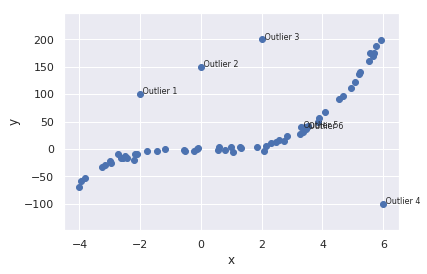

In [20]:
plt.scatter(concat[:,0],concat[:,1])
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(ylim)
ind = [-4, -3, -2, -1, 22, 35]
for i, txt in enumerate(ind):
    plt.text(concat[txt][0],concat[txt][1], ' Outlier ' + str(i+1), fontsize=8)
if noise_std == 0:
    plt.savefig('./Results_IRT/' + name.split('_')[0] + '/original.png')

In [21]:
print(parameters.sort_values(by= 'difficulty', ascending= False).head())
print(parameters.sort_values(by= 'discrimination', ascending= True).head())

     difficulty  discrimination
119    0.633189        0.285213
249    0.605955        0.286218
2      0.561984        0.346875
278    0.556700        0.547092
1      0.545774        0.486955
     difficulty  discrimination
3      0.516435        0.068034
0      0.538648        0.253824
237    0.488976        0.260477
119    0.633189        0.285213
249    0.605955        0.286218


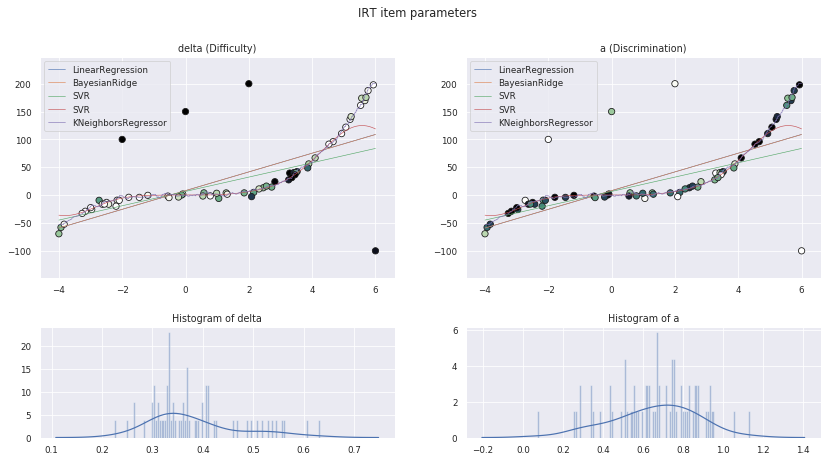

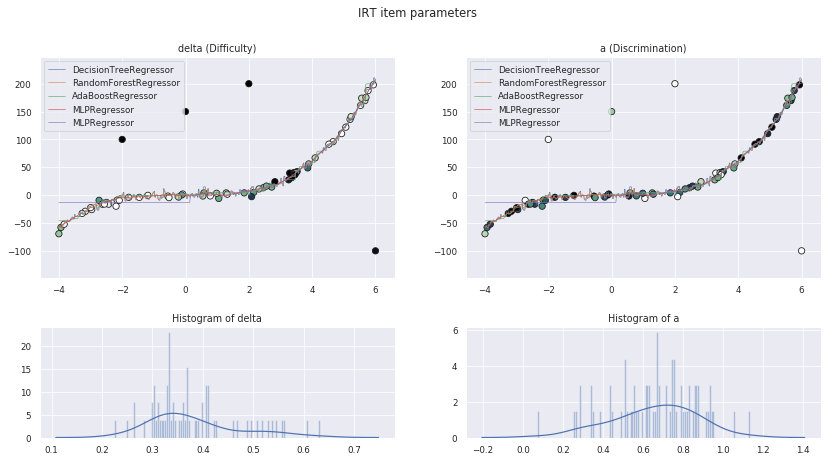

In [22]:
for i, l in enumerate([slice(0, 5, 1), slice(5, 10, 1)]):
    if noise_std > 0:
        f = plot_parameters(concat, delta = difficulty, a = discrimination, noise = noise, models= Irt.models[l], ylim= ylim)
    else:
        f = plot_parameters(concat, delta = difficulty, a = discrimination, models= Irt.models[l], ylim = ylim)
    f.savefig('./Results_IRT/' + name.split('_')[0] + '/params_'+str(i+1)+'.png')

In [23]:
chosen_i = [-4, -3, -2, -1]

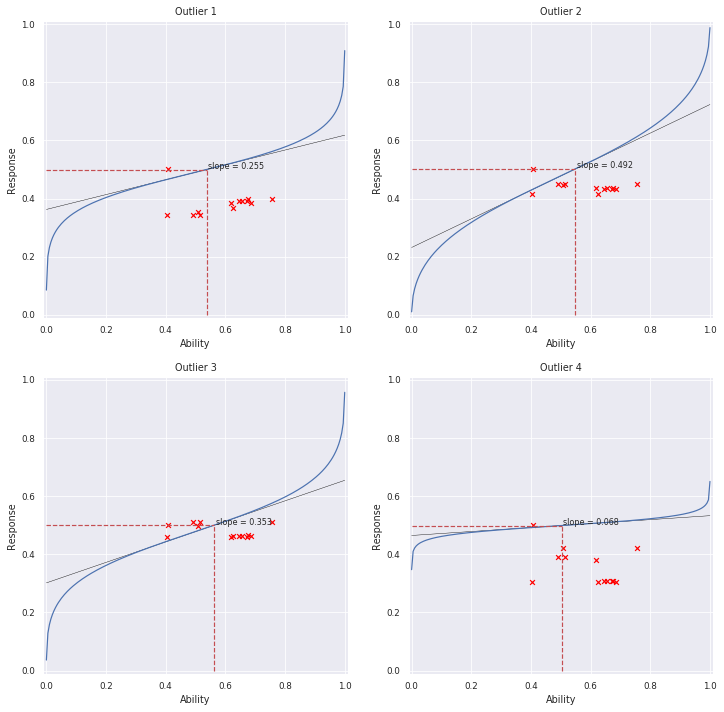

In [24]:
plt.figure(figsize=(12, 12))
for sub, i in enumerate(chosen_i):
    plt.subplot(2, 2, sub+1)
    par = parameters.iloc[i,:].values
    diff = par[0]
    disc = par[1]
    E = [beta_irt(x, diff, disc) for x in ab]
    middle = np.where(np.array(E)>0.499)[0][:2]
    p1 = [ab[middle[0]], E[middle[0]]]
    p2 = [ab[middle[1]], E[middle[1]]]
    newline(p1,p2)
    slope = (E[middle[1]] - E[middle[0]])/(ab[middle[1]] - ab[middle[0]])
    plt.text(p2[0], p2[1], 'slope = '+str(round(slope, 3)),fontsize=8)
    plt.plot(ab, E,)
    plt.plot([ab[middle[0]], ab[middle[0]]],[0, E[middle[0]]], '--r')
    plt.plot([0, ab[middle[0]]],[E[middle[0]], E[middle[0]]], '--r')
    plt.scatter(abilities['ability'].values[:-1], irt.iloc[i].values, marker= 'x', c = 'red')
    plt.ylabel('Response')
    plt.xlabel('Ability')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.title('Outlier ' + str(sub+1))
plt.savefig('./Results_IRT/' + name.split('_')[0] + '/instances.png')

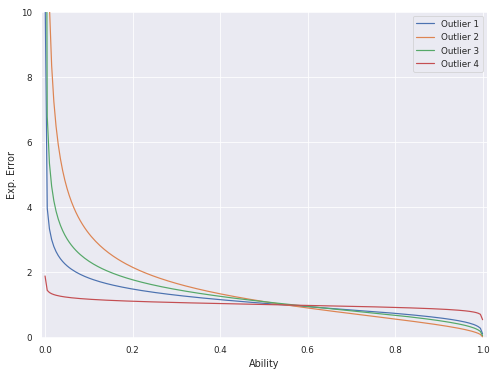

In [25]:
plt.figure(figsize=(8, 6))
for sub, i in enumerate(chosen_i):
#     plt.subplot(2, 2, sub+1)
    par = parameters.iloc[i,:].values
    diff = par[0]
    disc = par[1]
    E = np.array([beta_irt(x, diff, disc) for x in ab])
    Error = (1 - E)/E
    plt.plot(ab, Error, label = 'Outlier ' + str(sub + 1))
#     plt.plot([ab[middle[0]], ab[middle[0]]],[0, E[middle[0]]], '--r')
#     plt.plot([0, ab[middle[0]]],[E[middle[0]], E[middle[0]]], '--r')
    err = irt.iloc[i].values
#     plt.scatter(abilities['ability'].values[:-1], (1-err)/err, marker= 'x', c = 'red')
    plt.ylabel('Exp. Error')
    plt.xlabel('Ability')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 10.01])
#     plt.title('')
plt.legend()
plt.savefig('./Results_IRT/' + name.split('_')[0] + '/error_ability.png')

Moving IRT files to 'Results_IRT' folder:

In [ ]:
!mv {'./beta_irt/irt_data_' + name + '.csv'} {'./Results_IRT/' + name.split('_')[0] + '/'}
!mv {'./beta_irt/xtest_' + name + '.csv'} {'./Results_IRT/' + name.split('_')[0] + '/'}
!mv {'./beta_irt/errors_' + name + '.txt'} {'./Results_IRT/' + name.split('_')[0] + '/'}
!mv {path + folder + 'irt_ability_vi_'+ name +'_am1@0_as1@0.csv'} {'./Results_IRT/' + name.split('_')[0] + '/'}
!mv {path + folder + 'irt_parameters_vi_'+ name +'_am1@0_as1@0.csv'} {'./Results_IRT/' + name.split('_')[0] + '/'}